# Lectura de datasets

In [1]:
import sqlite3
import pandas as pd

# Nombre fichero
db_path = 'F1_timingdata_2014_2019.sqlite'


# Conexión a SQLlite
conn = sqlite3.connect(db_path)
# Leer la tabla 'laps'

laps_query = "SELECT l.* FROM laps l JOIN races r ON l.race_id = r.id WHERE r.location = 'Catalunya';"
laps_data = pd.read_sql_query(laps_query, conn)

# Mostrar las primeras filas
print("Muestra de la tabla laps:")
print(laps_data.head())

# Cerrar la conexión
conn.close()

Muestra de la tabla laps:
   race_id  lapno  position  driver_id  laptime  racetime  gap  interval  \
0        5      0         1          1      NaN       0.0  NaN       NaN   
1        5      0         2          3      NaN       0.0  NaN       NaN   
2        5      0         3          2      NaN       0.0  NaN       NaN   
3        5      0         4         15      NaN       0.0  NaN       NaN   
4        5      0         5         22      NaN       0.0  NaN       NaN   

  compound  tireage pitintime  pitstopduration nextcompound  startlapprog_vsc  \
0       A2        2      None              NaN         None               NaN   
1       A2        2      None              NaN         None               NaN   
2       A2        2      None              NaN         None               NaN   
3       A2        2      None              NaN         None               NaN   
4       A2        2      None              NaN         None               NaN   

   endlapprog_vsc  age_vsc  st

# Lectura de máximo de vueltas para el circuito

In [2]:
# Reabrir conexión a la base de datos
conn = sqlite3.connect(db_path)

# Leer la tabla 'laps'
nolaps_query = "SELECT AVG(nolapsplanned) AS avg_nolapsplanned FROM races WHERE location = 'Catalunya';"
avg_nolapsplanned = pd.read_sql_query(nolaps_query, conn)

# Mostrar las primeras filas
print("Muestra de la tabla laps:")
avg_nolapsplanned_value = int(avg_nolapsplanned.loc[0, 'avg_nolapsplanned']) 

print(avg_nolapsplanned_value)

# Cerrar la conexión
conn.close()

Muestra de la tabla laps:
66


# EDA. Limpieza de primeras vueltas y definición de tamaño de secuencia

In [3]:
# Tamaño secuencias
tam_sequence = 10

# Eliminar vueltas iniciales y filas con tiempos nulos
laps_cleaned = laps_data[laps_data['lapno'] > 0].copy()

# Crear columnas adicionales
laps_cleaned['is_pitstop'] = laps_cleaned['pitstopduration'].notnull().astype(int)  # Identificar paradas en pits
laps_cleaned['compound_pitstop'] = laps_cleaned['nextcompound'].notnull().astype(int)  # Identificar paradas en pits
laps_cleaned['affected_by_vsc'] = laps_cleaned['age_vsc'].notnull().astype(int)    # Fase VSC activa
laps_cleaned['affected_by_sc'] = laps_cleaned['age_sc'].notnull().astype(int)      # Fase SC activa
laps_cleaned['raceprogress'] = laps_cleaned['lapno'] / avg_nolapsplanned_value
# Mostrar una muestra del dataset limpio
print("Muestra de los datos procesados:")
print(laps_cleaned.head())

Muestra de los datos procesados:
    race_id  lapno  position  driver_id  laptime  racetime    gap  interval  \
22        5      1         1          1   96.072    96.072  0.000     0.000   
23        5      1         2          3   97.222    97.222  1.150     1.150   
24        5      1         3         15   98.418    98.418  2.346     1.196   
25        5      1         4          2   98.993    98.993  2.921     0.575   
26        5      1         5         22  100.112   100.112  4.040     1.119   

   compound  tireage  ... endlapprog_vsc  age_vsc startlapprog_sc  \
22       A2        3  ...            NaN      NaN             NaN   
23       A2        3  ...            NaN      NaN             NaN   
24       A2        3  ...            NaN      NaN             NaN   
25       A2        3  ...            NaN      NaN             NaN   
26       A2        3  ...            NaN      NaN             NaN   

    endlapprog_sc  age_sc  is_pitstop  compound_pitstop  affected_by_vsc  \
2

# EDA. Escalado y codificación variables categóricas

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


# Asignar una instancia del evaluador
# 1. Codificar 'compound' con LabelEncoder
label_encoder = LabelEncoder()
laps_cleaned['compound_encoded'] = label_encoder.fit_transform(laps_cleaned['compound'])
laps_cleaned = laps_cleaned.drop('compound', axis=1)

# Asignar una instancia del evaluador
# 1. Codificar 'compound' con LabelEncoder
label_encoder_next = LabelEncoder()
# 1. Reemplazar valores None/NaN con un marcador temporal (ej: 'NoneType')
laps_cleaned['nextcompound'] = laps_cleaned['nextcompound'].fillna('NoneType')
laps_cleaned['nextcompound_encoded'] = label_encoder_next.fit_transform(laps_cleaned['nextcompound'])
# 3. Asignar valor 0 a la categoría 'NoneType'
laps_cleaned['nextcompound_encoded'] = laps_cleaned['nextcompound_encoded'].where(
    laps_cleaned['nextcompound'] != 'NoneType', 0
)
laps_cleaned = laps_cleaned.drop('nextcompound', axis=1)

# 2. Escalar solo las columnas numéricas
numerical_columns = ['laptime','tireage','position','gap']
scaler = MinMaxScaler(feature_range=(0, 1))

# Aplicar el escalado solo a las columnas numéricas
laps_cleaned[numerical_columns] = scaler.fit_transform(laps_cleaned[numerical_columns])

counter = 0

## Crear secuencias por piloto y carrera
def create_sequences_grouped(df, group_by_cols, cols, seq_len, step):
    sequences = []
    grouped = df.groupby(group_by_cols)
    for _, group in grouped:
        # Ordenar las vueltas dentro del grupo
        group = group.sort_values('lapno')
        group_data = group[cols].values
        for i in range(0, len(group_data) - seq_len + 1, step):  # Incrementa con 'step'
            sequences.append(group_data[i:i+seq_len])
    return np.array(sequences)

## Ajustar número de vueltas
def create_sequences_with_additional_data(df, cols, group_by_cols, seq_len, step, counter):

    sequences = []
    grouped = df.groupby(group_by_cols)
    
    for group_keys, group in grouped:
        # Ordenar las vueltas dentro del grupo
        group = group.sort_values('lapno')
        driver_id, race_id = group_keys
        
        # Calcular columnas adicionales
        group['cumulative_pitstops'] = group['is_pitstop'].cumsum()  # Número de paradas realizadas hasta el momento
        group['max_pitstops'] = group['is_pitstop'].sum()  # Número máximo de paradas en toda la carrera
           # Escalar las columnas adicionales usando el mismo escalador
        
        # Seleccionar las columnas necesarias
        group_data = group[cols].values

        # Crear ventanas deslizantes
        for i in range(0, len(group_data) - seq_len + 1, step):  # Incrementa con 'step'
            print(f"Driver ID: {driver_id}, Race ID: {race_id}")
            print ("sequence added", counter)
            sequences.append(group_data[i:i+seq_len])
            counter = counter + 1
    
    return np.array(sequences)

columns_to_use_cond = ['raceprogress','laptime','tireage','position','gap','compound_encoded','cumulative_pitstops','max_pitstops']
columns_to_use_gen = ['is_pitstop', 'nextcompound_encoded']

# Crear secuencias y separación de conjunto test y entrenamiento

In [5]:
# Generar secuencias condicionantes
sequences_cond = create_sequences_with_additional_data(
    df=laps_cleaned,
    group_by_cols=['driver_id', 'race_id'],
    cols=columns_to_use_cond,
    seq_len=tam_sequence,
    step = tam_sequence,
    counter = counter
)

# Generar secuencias con soluciones
sequences_gen = create_sequences_grouped(
    df=laps_cleaned,
    group_by_cols=['driver_id', 'race_id'],
    cols=columns_to_use_gen,
    seq_len=tam_sequence,
    step = tam_sequence
)

# Proporción de división
train_ratio = 0.8  # Usar el 80% para entrenamiento y el 20% para prueba

# Calcular el índice de división
split_idx = int(len(sequences_cond) * train_ratio)
print (split_idx)

# Dividir las secuencias condicionales (manteniendo el orden)
train_sequences_cond = sequences_cond[:split_idx]
test_sequences_cond = sequences_cond[split_idx:]

# Dividir las secuencias generadas (manteniendo el orden)
train_sequences_gen = sequences_gen[:split_idx]
test_sequences_gen = sequences_gen[split_idx:]

print("\nEjemplo de Secuencia condicional de entrenamiento:")
print(train_sequences_cond[0])
print("\nEjemplo de Secuencia condicional de test:")
print(test_sequences_cond[0])

Driver ID: 1, Race ID: 5
sequence added 0
Driver ID: 1, Race ID: 5
sequence added 1
Driver ID: 1, Race ID: 5
sequence added 2
Driver ID: 1, Race ID: 5
sequence added 3
Driver ID: 1, Race ID: 5
sequence added 4
Driver ID: 1, Race ID: 5
sequence added 5
Driver ID: 1, Race ID: 24
sequence added 6
Driver ID: 1, Race ID: 24
sequence added 7
Driver ID: 1, Race ID: 24
sequence added 8
Driver ID: 1, Race ID: 24
sequence added 9
Driver ID: 1, Race ID: 24
sequence added 10
Driver ID: 1, Race ID: 24
sequence added 11
Driver ID: 1, Race ID: 64
sequence added 12
Driver ID: 1, Race ID: 64
sequence added 13
Driver ID: 1, Race ID: 64
sequence added 14
Driver ID: 1, Race ID: 64
sequence added 15
Driver ID: 1, Race ID: 64
sequence added 16
Driver ID: 1, Race ID: 64
sequence added 17
Driver ID: 1, Race ID: 84
sequence added 18
Driver ID: 1, Race ID: 84
sequence added 19
Driver ID: 1, Race ID: 84
sequence added 20
Driver ID: 1, Race ID: 84
sequence added 21
Driver ID: 1, Race ID: 84
sequence added 22
Driv

# Lanzar entrenamiento

In [6]:
# Código no incluido al no poder distribuir modificaciones sobre TCGAN original

2025-01-27 18:36:34.897942: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-01-27 18:36:34.897979: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


****** configure init ******


2025-01-27 18:36:38.327653: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2025-01-27 18:36:38.611664: E tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:968] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-27 18:36:38.611697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:26:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.8GHz coreCount: 30 deviceMemorySize: 6.00GiB deviceMemoryBandwidth: 312.97GiB/s
2025-01-27 18:36:38.611764: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2025-01-27 18:36:38.611803: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic li

The settings are as follows: 
strides:2
padding:same
initializer:<tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal object at 0x7f45c5ffcfd0>
leak_slope:0.2
logger:<__main__.Logger object at 0x7f45ed7dd190>
log_dir:./logs
train_dir:./logs/training
eval_dir:./logs/evaluation
ckpt_dir:./logs/checkpoint
ckpt_prefix:./logs/checkpoint/ckpt
seed:42
np_rs:RandomState(MT19937)
verbose:0
x_shape:(10, 2)
cond_shape:(10, 8)
y_shape:(10, 2)
noise_shape:(100,)
noise_method:normal
noise_sampler:<function random_normal at 0x7f45a2929710>
batch_size:16
epochs:2000
g_lr:0.0002
d_lr:0.0002
g_beta1:0.5
d_beta1:0.5
g_units_base:32
d_units_base:32
d_layers:4
g_layers:4
d_dropout_rate:0.0
g_norm:<class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>
d_norm:<class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>
kernel_size:5
acc_threshold_to_train_d:1.0
ckpt_max_to_keep:5
n_epochs_to_save_ckpt:15
n_to_evaluate:3
n_epochs_to_evaluate:666
n_example

# Generación de estrategias con el modelo ya entrenado

In [7]:
# Lista para almacenar todas las secuencias generadas
generated_sequences = []

# Iterar sobre cada secuencia en test_sequences_cond
for i, cond in enumerate(test_sequences_cond):
    # Asegurarse de que la condición tenga las dimensiones correctas
    cond = cond[np.newaxis, :]  # Añadir una dimensión extra si es necesario
    print(f"Secuencia Condición {i}:", cond)
    print("Forma de la condición seleccionada:", cond.shape)
    
    # Generar una secuencia basada en la condición
    n_samples = cond.shape[0]
    generated_sequence = model.generate_data(n_samples, cond)
    
    # Guardar la secuencia generada en la lista
    generated_sequences.append(generated_sequence)
    print(f"Secuencia Generada {i}:", generated_sequence)

# Convertir la lista a un array de numpy si es necesario
generated_sequences = np.array(generated_sequences)

print("Todas las Secuencias Generadas:", generated_sequences)

Secuencia Condición 0: [[[0.77272727 0.02272934 0.34782609 0.0952381  0.07151811 2.
   1.         1.        ]
  [0.78787879 0.01631151 0.36956522 0.0952381  0.07124269 2.
   1.         1.        ]
  [0.8030303  0.02174111 0.39130435 0.0952381  0.07259146 2.
   1.         1.        ]
  [0.81818182 0.01517561 0.41304348 0.0952381  0.07199944 2.
   1.         1.        ]
  [0.83333333 0.0146531  0.43478261 0.0952381  0.0716674  2.
   1.         1.        ]
  [0.84848485 0.01212004 0.45652174 0.0952381  0.07088748 2.
   1.         1.        ]
  [0.86363636 0.01219955 0.47826087 0.0952381  0.07107281 2.
   1.         1.        ]
  [0.87878788 0.01315371 0.5        0.0952381  0.07135852 2.
   1.         1.        ]
  [0.89393939 0.01380117 0.52173913 0.0952381  0.07146663 2.
   1.         1.        ]
  [0.90909091 0.01438048 0.54347826 0.0952381  0.06603038 2.
   1.         1.        ]]]
Forma de la condición seleccionada: (1, 10, 8)
Secuencia Generada 0: [[[ 0.01600658  0.00100831]
  [ 0.00

# Desescalado y presentación de gráficos de las soluciones generadas

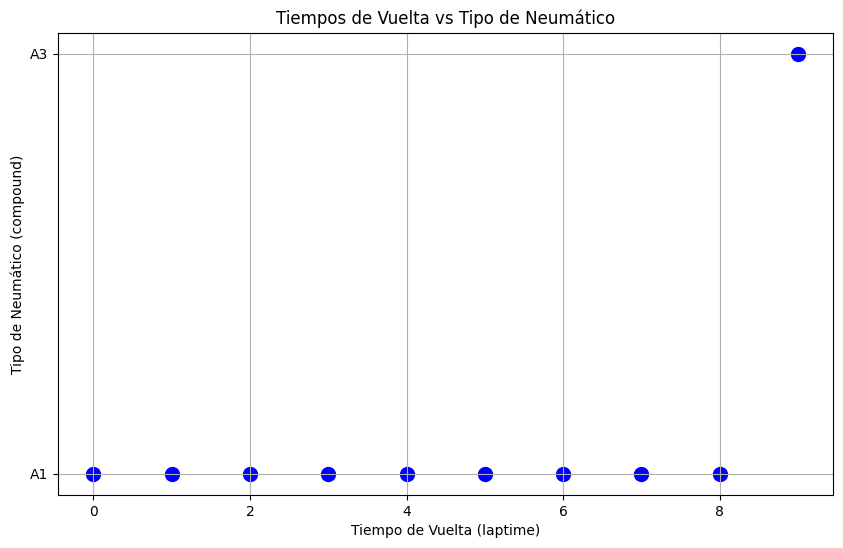

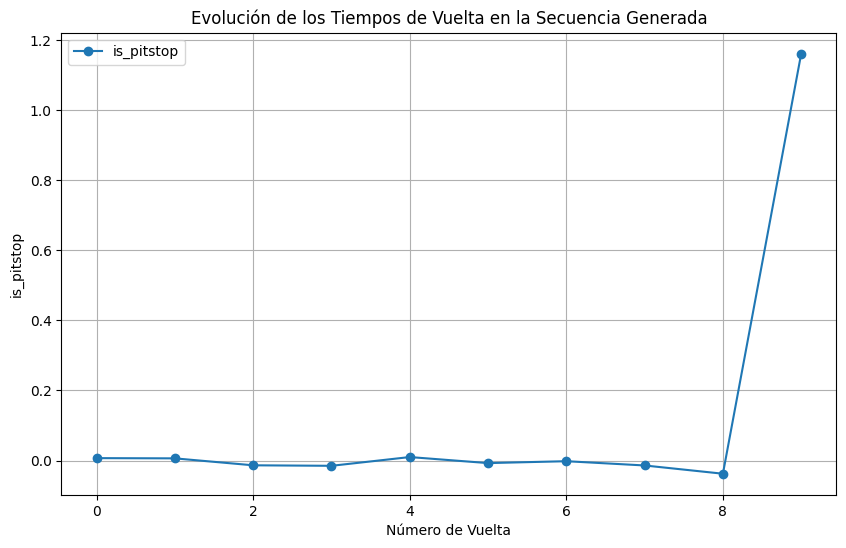

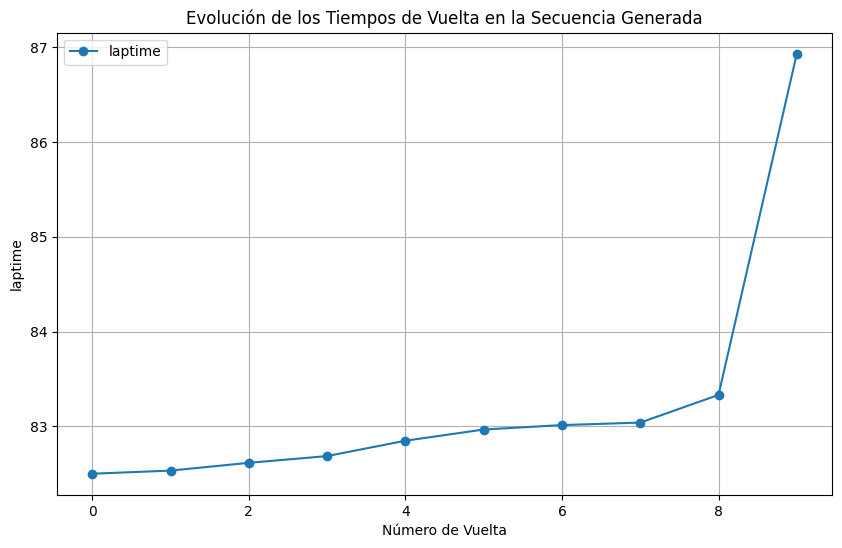

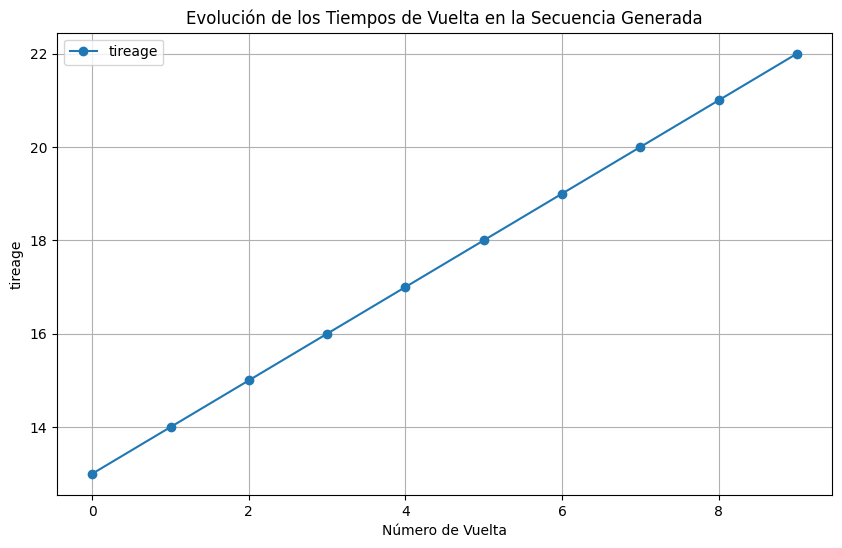

In [8]:
import matplotlib.pyplot as plt


def desescalar_numericas(scaler, sequence, sample, all_columns, columns_to_desescalar):

    # Reducir la dimensión del array para trabajar con (seq_len, n_features)
    sequence_2d = sequence[sample]  # Remover dimensión extra

    # Identificar los índices de las columnas a desescalar
    indices_to_desescalar = [all_columns.index(col) for col in columns_to_desescalar]

    # Separar las columnas a desescalar
    to_desescalar = sequence_2d[:, indices_to_desescalar]

    # Desescalar las columnas numéricas
    descaled_data = scaler.inverse_transform(to_desescalar)

    # Crear un DataFrame para todas las columnas
    descaled_df = pd.DataFrame(sequence_2d, columns=all_columns)

    # Reemplazar las columnas desescaladas en el DataFrame
    for i, col in enumerate(columns_to_desescalar):
        descaled_df[col] = descaled_data[:, i]

    return descaled_df


def desescalar_categoricas(sequence, all_columns, label_encoder):
    # Reducir la dimensión del array para trabajar con (seq_len, n_features)
    sequence_2d = sequence[0]  # Remueve la dimensión extra

    # Crear un DataFrame temporal con las columnas originales
    sequence_df = pd.DataFrame(sequence_2d, columns=all_columns)

    # Reconstruir la columna categórica 'nextcompound' desde 'nextcompound_encoded'
    sequence_df['nextcompound'] = label_encoder.inverse_transform(
        sequence_df['nextcompound_encoded'].round().astype(int)
    )

    # Eliminar la columna codificada si ya no es necesaria
    sequence_df = sequence_df.drop('nextcompound_encoded', axis=1)

    return sequence_df

sample_number=2
all_columns = ['raceprogress','laptime','tireage','position','gap','compound_encoded','cumulative_pitstops','max_pitstops']

# Llamar a la función para desescalar
descaled_df_cond = desescalar_numericas(
    scaler=scaler,
    sequence=test_sequences_cond,
    sample = sample_number,
    all_columns=all_columns,
    columns_to_desescalar=numerical_columns
)
# Desescalar la primera secuencia
descaled_df_gen = desescalar_categoricas(
    sequence=generated_sequences[sample_number],
    #sequence=test_sequences_gen,
    all_columns=columns_to_use_gen,
    label_encoder=label_encoder_next,
)

# Convertir el tipo de neumático en categorías numéricas para el eje Y
unique_compounds = descaled_df_gen['nextcompound'].unique()
compound_to_y = {compound: idx for idx, compound in enumerate(unique_compounds)}
descaled_df_gen['compound_y'] = descaled_df_gen['nextcompound'].map(compound_to_y)

# Gráfico
plt.figure(figsize=(10, 6))

# Dibujar cada punto con el tiempo de vuelta en el eje X y el tipo de neumático en el eje Y
plt.scatter(descaled_df_gen.index, descaled_df_gen['compound_y'], color='blue', s=100)

# Personalizar el eje Y para mostrar las etiquetas originales de neumáticos
plt.yticks(ticks=list(compound_to_y.values()), labels=list(compound_to_y.keys()))

# Configuración de la gráfica
plt.title('Tiempos de Vuelta vs Tipo de Neumático')
plt.xlabel('Tiempo de Vuelta (laptime)')
plt.ylabel('Tipo de Neumático (compound)')
plt.grid(True)
plt.show()

# Graficar la secuencia de tiempos de vuelta (laptime)
plt.figure(figsize=(10, 6))
plt.plot(descaled_df_gen.index, descaled_df_gen['is_pitstop'], marker='o', linestyle='-', label='is_pitstop')
plt.title("Evolución de los Tiempos de Vuelta en la Secuencia Generada")
plt.xlabel("Número de Vuelta")
plt.ylabel("is_pitstop")
plt.grid()
plt.legend()
plt.show()

# Graficar la secuencia de tiempos de vuelta (laptime)
plt.figure(figsize=(10, 6))
plt.plot(descaled_df_cond.index, descaled_df_cond['laptime'], marker='o', linestyle='-', label='laptime')
plt.title("Evolución de los Tiempos de Vuelta en la Secuencia Generada")
plt.xlabel("Número de Vuelta")
plt.ylabel("laptime")
plt.grid()
plt.legend()
plt.show()

# Graficar la secuencia de tiempos de vuelta (laptime)
plt.figure(figsize=(10, 6))
plt.plot(descaled_df_cond.index, descaled_df_cond['tireage'], marker='o', linestyle='-', label='tireage')
plt.title("Evolución de los Tiempos de Vuelta en la Secuencia Generada")
plt.xlabel("Número de Vuelta")
plt.ylabel("tireage")
plt.grid()
plt.legend()
plt.show()

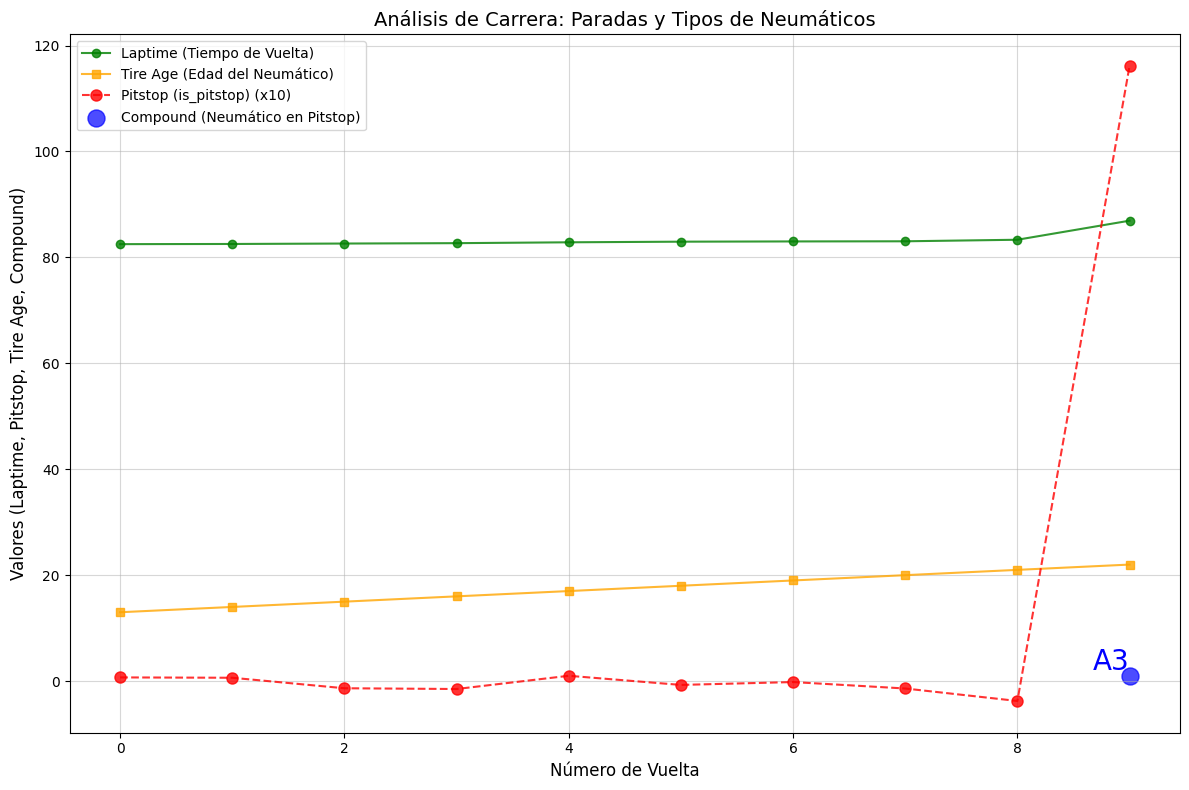

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Graficar laptime y tireage con líneas y marcadores estándar
ax1.plot(descaled_df_cond.index, descaled_df_cond['laptime'], color='green', marker='o', linestyle='-', label='Laptime (Tiempo de Vuelta)', alpha=0.8)
ax1.plot(descaled_df_cond.index, descaled_df_cond['tireage'], color='orange', marker='s', linestyle='-', label='Tire Age (Edad del Neumático)', alpha=0.8)

# Destacar is_pitstop (multiplicado por 10 para visibilidad) con marcador grande
ax1.plot(descaled_df_gen.index, descaled_df_gen['is_pitstop'] * 100, color='red', marker='o', linestyle='--', label='Pitstop (is_pitstop) (x10)', markersize=8, alpha=0.8)

# Filtrar y mostrar compound sólo donde is_pitstop > 0.5
filtered_indexes = descaled_df_gen.index[descaled_df_gen['is_pitstop'] > 0.5]
filtered_compounds = descaled_df_gen.loc[descaled_df_gen['is_pitstop'] > 0.5, 'compound_y']

# Dibujar los puntos de compound_y en los pitstops
ax1.scatter(filtered_indexes, filtered_compounds, color='blue', label='Compound (Neumático en Pitstop)', s=150, alpha=0.7)

# Añadir un label único para el neumático actual en cada pitstop
if 'compound_to_y' in locals():
    for idx, compound in zip(filtered_indexes, filtered_compounds):
        label = list(compound_to_y.keys())[list(compound_to_y.values()).index(compound)]
        ax1.annotate(label, (idx, compound), fontsize=20, ha='right', va='bottom', color='blue')

# Personalizar los ejes
ax1.set_xlabel("Número de Vuelta", fontsize=12)
ax1.set_ylabel("Valores (Laptime, Pitstop, Tire Age, Compound)", fontsize=12)
ax1.grid(True, alpha=0.5)
ax1.legend(loc='upper left', fontsize=10)

# Título de la gráfica
plt.title("Análisis de Carrera: Paradas y Tipos de Neumáticos", fontsize=14)

# Ajustar el diseño
fig.tight_layout()

# Mostrar la gráfica
plt.show()

# Cálculo de métricas

In [ ]:
def rbf_kernel(x, y, gamma=None):
    if gamma is None:
        gamma = 1.0 / x.shape[1]  # Asume que x e y son 2D
    dist_sq = np.sum((x - y)**2)
    return np.exp(-gamma * dist_sq)

def compute_mmd(X, Y, gamma=None):
    n = X.shape[0]
    m = Y.shape[0]

    # Suma de k(x, x')
    xx = 0.0
    for i in range(n):
        for j in range(n):
            xx += rbf_kernel(X[i:i+1], X[j:j+1], gamma)  # Asegura submatrices 2D
    xx /= (n * n)

    # Suma de k(y, y')
    yy = 0.0
    for i in range(m):
        for j in range(m):
            yy += rbf_kernel(Y[i:i+1], Y[j:j+1], gamma)
    yy /= (m * m)

    # Suma de k(x, y)
    xy = 0.0
    for i in range(n):
        for j in range(m):
            xy += rbf_kernel(X[i:i+1], Y[j:j+1], gamma)
    xy /= (n * m)

    mmd2 = xx + yy - 2.0 * xy
    return mmd2

def mmd_distance(real_data, gen_data, gamma=None):
    mmd2 = compute_mmd(real_data, gen_data, gamma=gamma)
    return np.sqrt(mmd2)

generated_sequences = np.squeeze(generated_sequences, axis=1)

distance = mmd_distance(test_sequences_gen, generated_sequences)
print("MMD distance:", distance)

import numpy as np
import ot  # 'pot' library

def wasserstein_distance(real_data, gen_data):

    # Calcular la matriz de costos (distancia euclidiana)
    cost_matrix = ot.dist(real_data, gen_data, metric='euclidean')

    # Crear los vectores de probabilidades compatibles con los datos
    p = np.ones((real_data.shape[0],)) / real_data.shape[0]
    q = np.ones((gen_data.shape[0],)) / gen_data.shape[0]

    # Calcular la distancia de Wasserstein usando ot.emd2
    wasserstein = ot.emd2(p, q, cost_matrix)
    return wasserstein

n_timesteps = test_sequences_gen.shape[1]  # 52 pasos temporales
wasserstein_distances = []

for t in range(n_timesteps):
    # Extraer las características para el paso t
    step_real = test_sequences_gen[:, t, :]  # Forma: (n_samples, 4)
    step_gen = generated_sequences[:, t, :]  # Forma: (n_samples, 4)

    cost_matrix = ot.dist(step_real, step_gen, metric='euclidean')

    n_real = step_real.shape[0]
    n_gen = step_gen.shape[0]
    p = np.ones((n_real,)) / n_real
    q = np.ones((n_gen,)) / n_gen
   
    # Calcular distancia de Wasserstein para el paso t
    wasserstein = ot.emd2(p, q, cost_matrix)
    print("Wasserstein en iteración", wasserstein)
    wasserstein_distances.append(wasserstein)

# Promediar las distancias por paso temporal
mean_wasserstein = np.mean(wasserstein_distances)
print("Wasserstein distance (por pasos temporales):", mean_wasserstein)

sequences_flat = test_sequences_gen.reshape(test_sequences_gen.shape[0], -1)
generated_sequences_flat = generated_sequences.reshape(generated_sequences.shape[0], -1)

distance = wasserstein_distance(sequences_flat, generated_sequences_flat)
print("Wasserstein distance:", distance)

MMD distance: 0.05713648041685592
Wasserstein en iteración 0.16017878637774047
Wasserstein en iteración 0.05050424981085086
Wasserstein en iteración 0.026698806199208138
Wasserstein en iteración 0.022963696820021817
Wasserstein en iteración 0.009004384143756363
Wasserstein en iteración 0.020517009350710613
Wasserstein en iteración 0.011701408492411339
Wasserstein en iteración 0.019042358115715495
Wasserstein en iteración 0.020018360727769063
Wasserstein en iteración 0.043744968015570686
Wasserstein distance (por pasos temporales): 0.038437402805375484
Wasserstein distance: 0.2635436194566537


In [11]:
# Inicializar contadores
total_vueltas = 0
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

# Iterar sobre las secuencias
for i in range(len(generated_sequences)):
    real_seq = test_sequences_gen[i]  # Secuencia real (66, 2)
    gen_seq = generated_sequences[i]   # Secuencia generada (66, 2)

    # Extraer indicadores de parada
    real_parada = real_seq[:, 0]       # Primera columna: indicador de parada
    gen_parada = gen_seq[:, 0]         # Predicción de parada (probabilidad)

    # Verificar coincidencias por vuelta
    for vuelta in range(len(real_parada)):
        total_vueltas += 1
        
        # Clasificar la predicción como positiva o negativa según el umbral
        pred_positive = gen_parada[vuelta] >= 0.5
        real_positive = real_parada[vuelta] == 1

        # Evaluar los casos
        if real_positive and pred_positive:  # Verdaderos positivos
            true_positives += 1
        elif not real_positive and not pred_positive:  # Verdaderos negativos
            true_negatives += 1
        elif not real_positive and pred_positive:  # Falsos positivos
            false_positives += 1
        elif real_positive and not pred_positive:  # Falsos negativos
            false_negatives += 1

# Calcular métricas
accuracy = (true_positives + true_negatives) / total_vueltas
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Resultados
print("Métricas de clasificación de paradas:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusión:")
print(f"Verdaderos Positivos (TP): {true_positives}")
print(f"Falsos Positivos (FP): {false_positives}")
print(f"Verdaderos Negativos (TN): {true_negatives}")
print(f"Falsos Negativos (FN): {false_negatives}")

Métricas de clasificación de paradas:
Exactitud (Accuracy): 0.99
Precisión (Precision): 1.00
Recall: 0.81
F1-Score: 0.90
Confusión:
Verdaderos Positivos (TP): 35
Falsos Positivos (FP): 0
Verdaderos Negativos (TN): 1287
Falsos Negativos (FN): 8


In [12]:
# Inicializar contadores
total_vueltas = 0
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
margen = 1  # Margen de 2 vueltas

# Iterar sobre las secuencias
for i in range(len(generated_sequences)):
    real_seq = test_sequences_gen[i]  # Secuencia real (66, 2)
    gen_seq = generated_sequences[i]   # Secuencia generada (66, 2)

    # Extraer indicadores de parada
    real_parada = real_seq[:, 0]       # Primera columna: indicador de parada
    gen_parada = gen_seq[:, 0]         # Predicción de parada (probabilidad)

    # Evaluar por vuelta con margen
    for vuelta in range(len(real_parada)):
        total_vueltas += 1

        # Clasificar como positiva o negativa según el umbral
        pred_positive = gen_parada[vuelta] >= 0.5
        real_positive = real_parada[vuelta] == 1

        if real_positive:
            # Buscar si hay una predicción en el rango de ±2 vueltas
            acierto_en_margen = any(
                gen_parada[max(0, vuelta - margen):min(len(gen_parada), vuelta + margen + 1)] >= 0.5
            )

            if acierto_en_margen:  # Verdadero positivo si cae dentro del margen
                true_positives += 1
            else:  # Falso negativo si no se predijo en el margen
                false_negatives += 1
        else:
            if pred_positive:  # Falso positivo
                false_positives += 1
            else:  # Verdadero negativo
                true_negatives += 1

# Calcular métricas
accuracy = (true_positives + true_negatives) / total_vueltas
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Resultados
print("Métricas de clasificación con margen de tolerancia:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusión:")
print(f"Verdaderos Positivos (TP): {true_positives}")
print(f"Falsos Positivos (FP): {false_positives}")
print(f"Verdaderos Negativos (TN): {true_negatives}")
print(f"Falsos Negativos (FN): {false_negatives}")


Métricas de clasificación con margen de tolerancia:
Exactitud (Accuracy): 0.99
Precisión (Precision): 1.00
Recall: 0.81
F1-Score: 0.90
Confusión:
Verdaderos Positivos (TP): 35
Falsos Positivos (FP): 0
Verdaderos Negativos (TN): 1287
Falsos Negativos (FN): 8
